# Sentiment Analysis

## Dataset
The dataset contains columns `polarity`, `title`, and `text`. Polarity can be either 1 (negative) or 2 (positive).

**In order to save time, only 40,000 rows of the train data set and 40,000 rows of the test data set will be used.**

## Read in, clean, and preprocess data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

In [2]:
df = pd.read_csv('/kaggle/input/amazon-reviews/train.csv',  header=None, nrows=40000)
df.columns = ['Polarity', 'Title', 'Review']
df.shape

(40000, 3)

In [3]:
df = df[['Polarity', 'Review']].reset_index(drop=True)
df.head(10)

,Polarity,Review
0,2,This sound track was beautiful! It paints the ...
1,2,I'm reading a lot of reviews saying that this ...
2,2,This soundtrack is my favorite music of all ti...
3,2,I truly like this soundtrack and I enjoy video...
4,2,"If you've played the game, you know how divine..."
5,2,I am quite sure any of you actually taking the...
6,1,"This is a self-published book, and if you want..."
7,2,I loved Whisper of the wicked saints. The stor...
8,2,I just finished reading Whisper of the Wicked ...
9,2,This was a easy to read book that made me want...


In [4]:
# Count the null values
df.isnull().sum()

Polarity    0
Review      0
dtype: int64

**The are no null values.**

In [5]:
# Count polarities
df.Polarity.value_counts(normalize = True)

Polarity
2    0.5086
1    0.4914
Name: proportion, dtype: float64

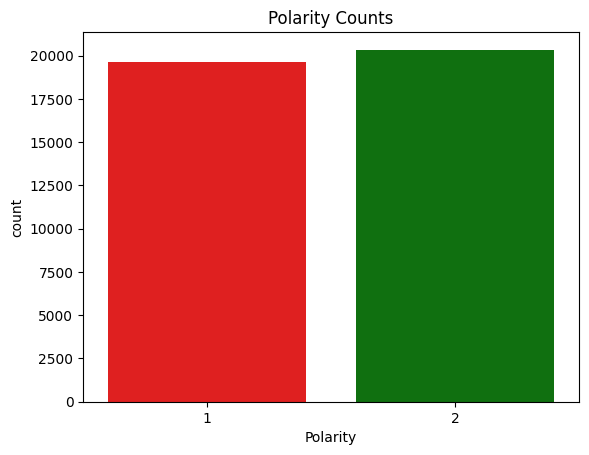

In [6]:
sns.set_palette(['red', 'green'])
sns.countplot(x=df['Polarity'])
plt.title('Polarity Counts')
plt.show()

**The data is balanced.**

In [7]:
def preprocess_text(text):
    # Make text lowercase and remove links, text in square brackets, punctuation, and words containing numbers
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+|\[.*?\]|[^a-zA-Z\s]+|\w*\d\w*', '', text)
    
    # Remove stop words
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    
    return ' '.join(filtered_words).strip()

In [8]:
# Apply preprocess_text to all data
df['Review'] = df['Review'].apply(preprocess_text)

In [9]:
df.head(10)

,Polarity,Review
0,2,sound track beautiful paints senery mind well ...
1,2,im reading lot reviews saying best game soundt...
2,2,soundtrack favorite music time hands intense s...
3,2,truly like soundtrack enjoy video game music p...
4,2,youve played game know divine music every sing...
5,2,quite sure actually taking time read played ga...
6,1,selfpublished book want know whyread paragraph...
7,2,loved whisper wicked saints story amazing plea...
8,2,finished reading whisper wicked saints fell lo...
9,2,easy read book made want keep reading easy put...


In [10]:
def stem_text(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Stem each token
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    # Join the stemmed tokens back into a single string
    return ' '.join(stemmed_tokens)

In [11]:
# Apply stem_text to all data
df['Review'] = df['Review'].apply(stem_text)

In [12]:
df.head(10)

,Polarity,Review
0,2,sound track beauti paint seneri mind well woul...
1,2,im read lot review say best game soundtrack fi...
2,2,soundtrack favorit music time hand intens sad ...
3,2,truli like soundtrack enjoy video game music p...
4,2,youv play game know divin music everi singl so...
5,2,quit sure actual take time read play game leas...
6,1,selfpublish book want know whyread paragraph s...
7,2,love whisper wick saint stori amaz pleasant su...
8,2,finish read whisper wick saint fell love carac...
9,2,easi read book made want keep read easi put do...


## Exploration Data Analysis (EDA)

In [13]:
# Count words from the 'Review' column
count = Counter(' '.join(df['Review']).split())

# Create a DataFrame from the word counts
words = pd.DataFrame(count.items(), columns=['Words', 'Frequency'])

# Sort by frequency and reset the index
words = words.sort_values('Frequency', ascending=False).reset_index(drop=True)

# Add a Rank column
words['Rank'] = words.index + 1
words = words[['Rank', 'Words', 'Frequency']]

words.head(20)


,Rank,Words,Frequency
0,1,book,28152
1,2,one,14948
2,3,read,14040
3,4,like,13032
4,5,movi,12683
5,6,good,9519
6,7,time,9324
7,8,get,9242
8,9,great,9132
9,10,would,9109


In [14]:
def generate_wordcloud(input):
    cloud = WordCloud(width=1500, height=800, max_words=500, background_color='black', colormap='coolwarm')
    wordcloud = cloud.generate(input)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

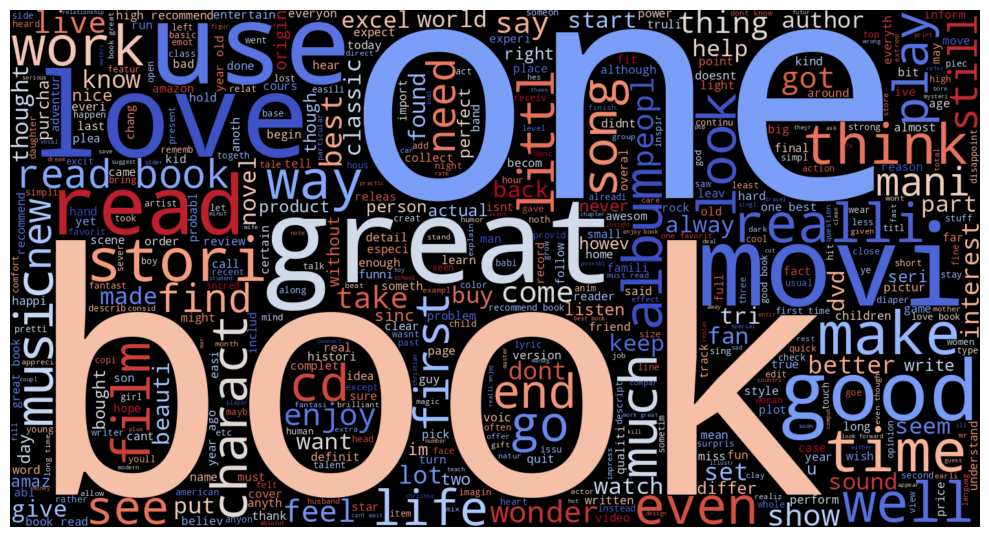

In [15]:
# Wordcloud for positive reviews
positive_words = " ".join(df[df['Polarity'] == 2]['Review'])
generate_wordcloud(positive_words)

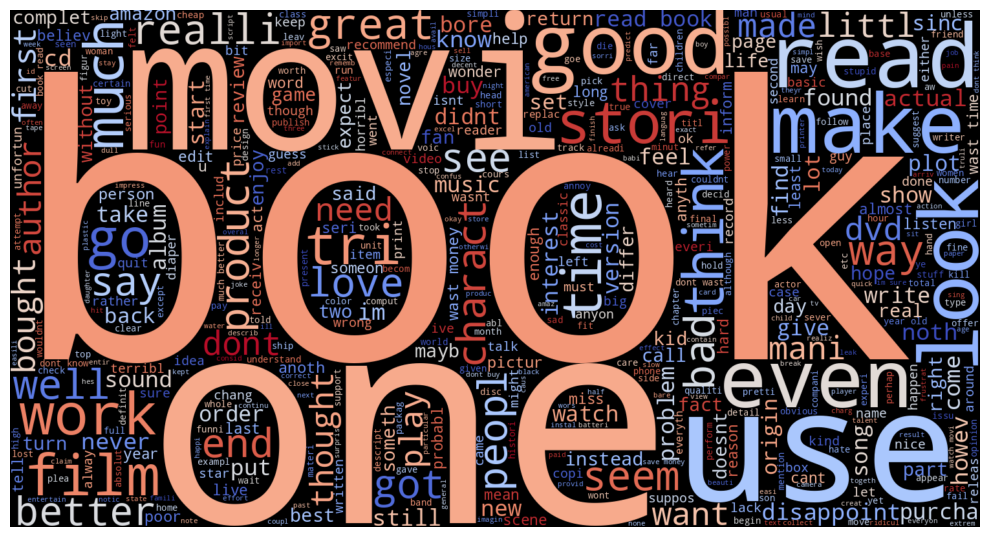

In [16]:
# Wordcloud for negative reviews
negative_words = " ".join(df[df['Polarity'] == 1]['Review'])
generate_wordcloud(negative_words)

In [17]:
def show_top_words(input, type):
    words = input.split()
    top_words = pd.DataFrame(Counter(words).most_common(25), columns=['Term', 'Count'])
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Count', y='Term', data=top_words, palette='coolwarm')
    plt.title(f"Top 25 Words in {type} Reviews")
    plt.xlabel("Occurrences")
    plt.ylabel("Terms")
    plt.tight_layout()
    plt.show()

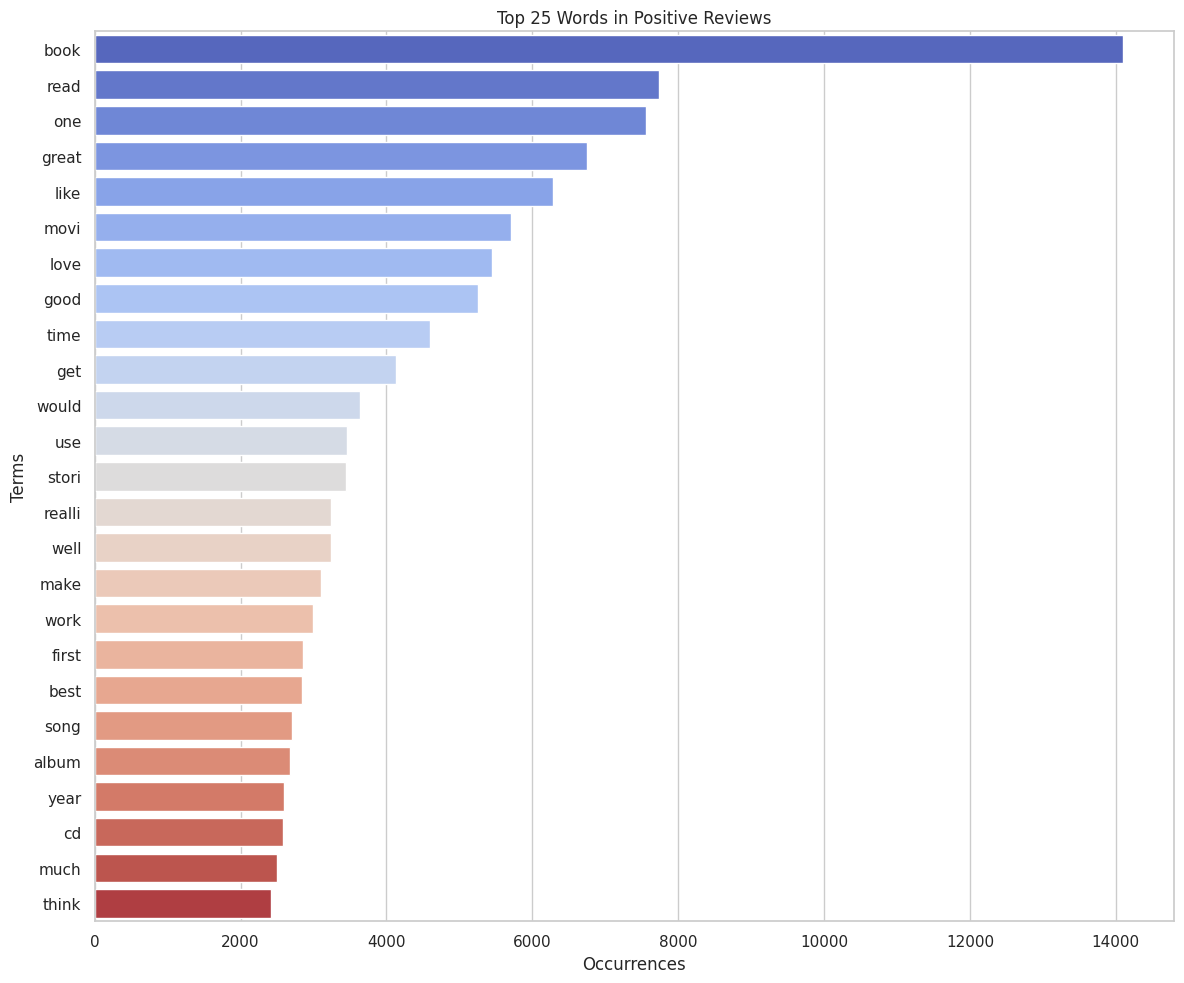

In [18]:
show_top_words(positive_words, "Positive")

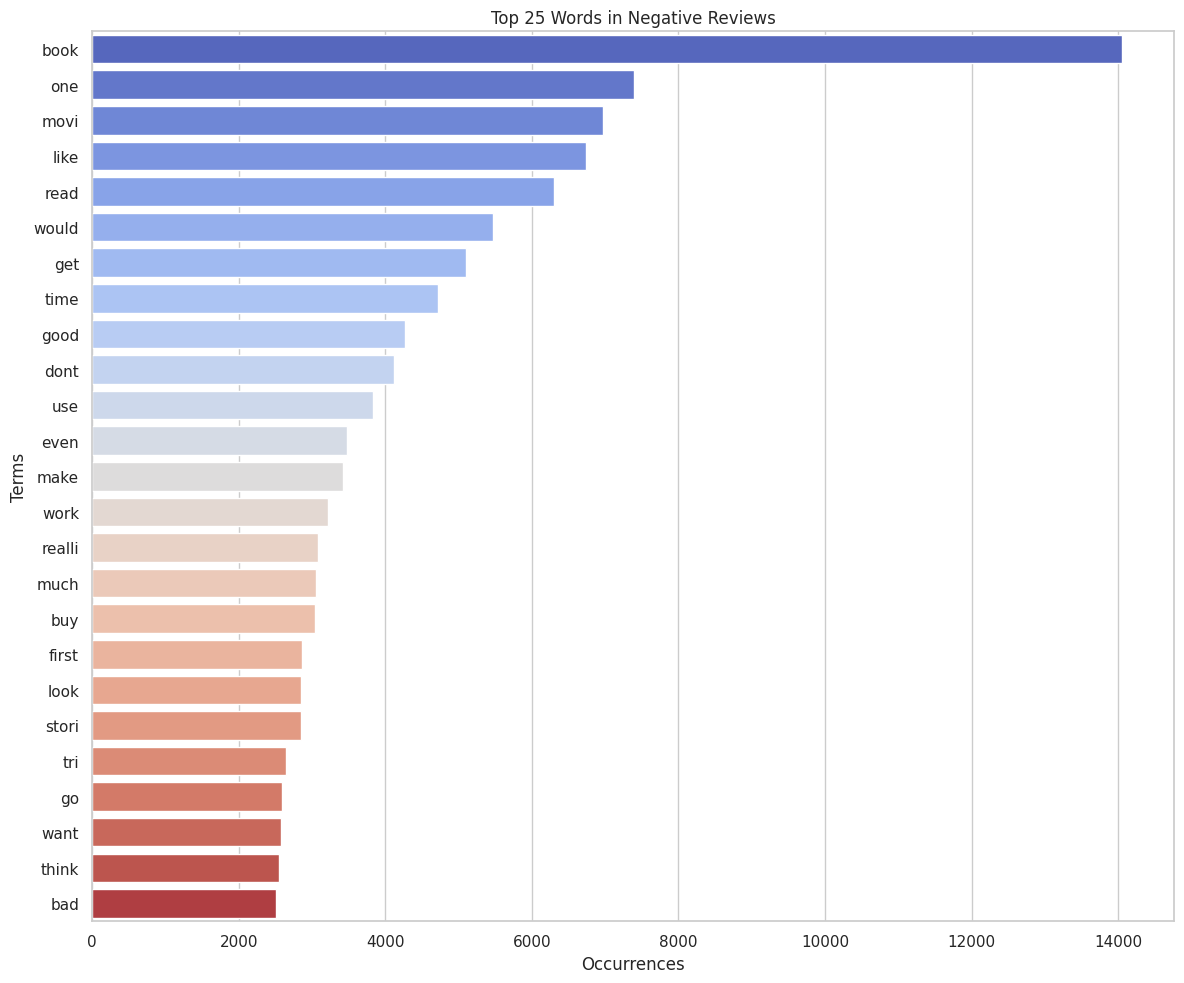

In [19]:
show_top_words(negative_words, "Negative")

## Training model

In [20]:
# Instantiate the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(df['Review'])
y_train = df['Polarity']

# Initialize the classifier
clf = LinearSVC()

# Train the classifier
clf.fit(X_train_tfidf, y_train)

LinearSVC()

In [21]:
# Reading the test dataset
test_df = pd.read_csv('/kaggle/input/amazon-reviews/test.csv', header=None, nrows=40000)
test_df.columns = ['Polarity', 'Title', 'Review']
test_df = test_df[['Polarity', 'Review']].reset_index(drop=True)

In [22]:
# Preprocessing test data
test_df['Review'] = test_df['Review'].apply(preprocess_text)
test_df['Review'] = test_df['Review'].apply(stem_text)

In [23]:
X_test_tfidf = tfidf_vectorizer.transform(test_df['Review'])

In [24]:
y_test = test_df['Polarity']
y_pred = clf.predict(X_test_tfidf)

In [25]:
# Printing out results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.846175

Classification Report:
               precision    recall  f1-score   support

           1       0.85      0.83      0.84     19641
           2       0.84      0.86      0.85     20359

    accuracy                           0.85     40000
   macro avg       0.85      0.85      0.85     40000
weighted avg       0.85      0.85      0.85     40000



In [26]:
def predict_sentiment(text):
    # Preprocess the input text
    preprocessed_text = stem_text(preprocess_text(text))
    
    # Transform the text using the trained tfidf_vectorizer
    features = tfidf_vectorizer.transform([preprocessed_text])
    
    # Predict using the trained classifier
    prediction = clf.predict(features)[0]
    
    # Return the sentiment
    if prediction == 1:
        return "Negative"
    else:
        return "Positive"

In [27]:
print(predict_sentiment("This has to be the worst software I've ever tried. Constant crashes and glitches!"))

Negative


In [28]:
print(predict_sentiment("Great value for the price! The product quality exceeded my expectations."))

Positive


In [29]:
print(predict_sentiment("Had high hopes after reading other reviews, but this just wasn't for me."))

Negative


In [30]:
print(predict_sentiment("Installation was a breeze and it integrated perfectly with my existing setup."))

Positive


In [31]:
print(predict_sentiment("Can't believe I wasted money on this. Extremely disappointing."))

Negative


In [32]:
print(predict_sentiment("The product description was misleading and the actual item was subpar."))

Negative


# Write a review

In [33]:
# Uncomment the lines below and run

# print("Write a review (and press Enter):")
# review = input()
# print("Sentiment: " + predict_sentiment(review))